In [1]:
# import the packages used for analysis
import nltk
import pandas as pd
import numpy as np
import string
import regex as re

import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud, STOPWORDS
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, recall_score
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn import feature_extraction, model_selection, metrics, svm

In [2]:
import datetime
import spacy
import math

In [3]:
data = pd.read_csv('Communication_and_high_tech.csv')      # reading data

In [4]:
data.head(5)

,Unnamed: 0,Time,Title,SubTitle,Declined Offer,Neutral Experience,Average Interview,Application,Interview,InterviewQuestions,date
0,1,"Apr 22, 2022",Legal Counsel Interview,Anonymous Interview Candidate,bad,neutral,neutral,I interviewed at Comcast,Multi-step interview process with long lulls b...,Behavioral questions and questions regarding m...,2022-04-22 00:00:00
1,2,"Apr 21, 2022",Software Engineer Interview,Anonymous Interview Candidate,bad,bad,neutral,I interviewed at Comcast,The interview was conducted online. 2 rounds w...,Describe many to many relationship in a database.,2022-04-21 00:00:00
2,3,"Apr 21, 2022",Customer Account Manager Interview,"Anonymous Employee in Abington, PA",good,bad,good,I applied through a recruiter. The process too...,"Initial online screening, phone screen with re...",Provide an example you overcame adversity,2022-04-21 00:00:00
3,4,"Apr 18, 2022",Digital Marketer Interview,Anonymous Interview Candidate,neutral,neutral,neutral,I interviewed at Comcast,The interview process was pretty standard real...,What have you done before that is similar to w...,2022-04-18 00:00:00
4,5,"Apr 14, 2022",Customer Onboarding Specialist Interview,"Anonymous Interview Candidate in Houston, TX",bad,bad,neutral,I applied online. The process took 4 weeks. I ...,"Applied online received assessment, received c...",What’s a time you had a customer upset and you...,2022-04-14 00:00:00


In [5]:
data['combined'] = data['Interview'] + ' ' +  data['InterviewQuestions']
data.iloc[0].combined

'Multi-step interview process with long lulls between the interviews. The interviews were more substantive as I progressing in the process. The initial interview was simply a screener with human resources. Behavioral questions and questions regarding my experience.'

In [6]:
data.loc[data.date <= '2019-12-31', 'period'] = 1
data.loc[(data.date > '2019-12-31') & (data.date <= '2020-06-30'), 'period'] = 2
data.loc[data.date > '2020-06-30', 'period'] = 3
data['period_count'] = data.groupby('period')['date'].transform(lambda a: len(set(a)))

#### Initialize data

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65535 entries, 0 to 65534
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Unnamed: 0          65535 non-null  int64  
 1   Time                65535 non-null  object 
 2   Title               65535 non-null  object 
 3   SubTitle            65535 non-null  object 
 4   Declined Offer      65535 non-null  object 
 5   Neutral Experience  65535 non-null  object 
 6   Average Interview   65535 non-null  object 
 7   Application         65535 non-null  object 
 8   Interview           65535 non-null  object 
 9   InterviewQuestions  65515 non-null  object 
 10  date                65535 non-null  object 
 11  combined            65515 non-null  object 
 12  period              65535 non-null  float64
 13  period_count        65535 non-null  int64  
dtypes: float64(1), int64(2), object(11)
memory usage: 7.0+ MB


array([[<AxesSubplot:title={'center':'bad'}>,
        <AxesSubplot:title={'center':'good'}>],
       [<AxesSubplot:title={'center':'neutral'}>, <AxesSubplot:>]],
      dtype=object)

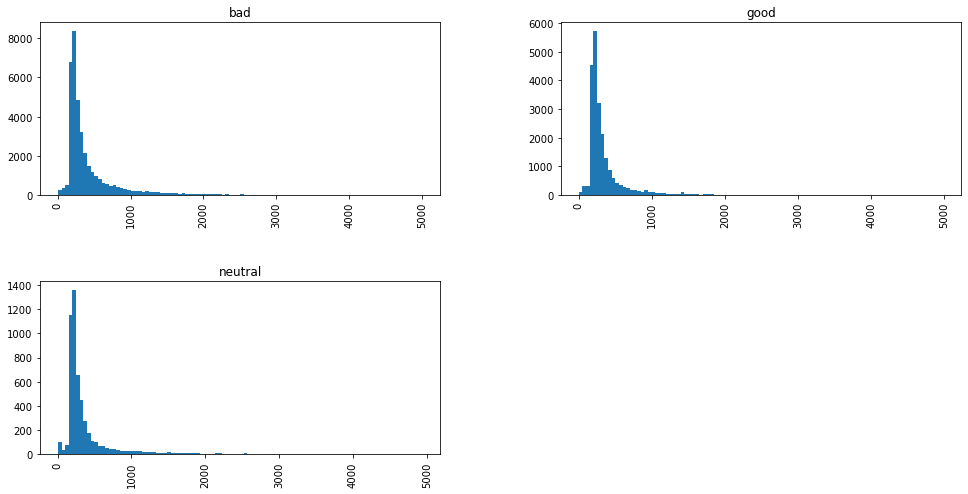

In [8]:
data['length'] = data['Interview'].apply(len)
data.hist(column='length',by='Declined Offer',bins=100, figsize=(16,8))

In [9]:
# Checking null/missing values
data.isnull().sum()

Unnamed: 0             0
Time                   0
Title                  0
SubTitle               0
Declined Offer         0
Neutral Experience     0
Average Interview      0
Application            0
Interview              0
InterviewQuestions    20
date                   0
combined              20
period                 0
period_count           0
length                 0
dtype: int64

In [10]:
data.InterviewQuestions

0        Behavioral questions and questions regarding m...
1        Describe many to many relationship in a database.
2                Provide an example you overcame adversity
3        What have you done before that is similar to w...
4        What’s a time you had a customer upset and you...
                               ...                        
65530    Are you prepared to code for most of your work...
65531    Why did you like least about your previous job...
65532    Did you face a situation where you had to fire...
65533    What would you to improve the function of my c...
65534    What is the difference between C and Java? And...
Name: InterviewQuestions, Length: 65535, dtype: object

In [11]:
data = data.fillna("")
data

,Unnamed: 0,Time,Title,SubTitle,Declined Offer,Neutral Experience,Average Interview,Application,Interview,InterviewQuestions,date,combined,period,period_count,length
0,1,"Apr 22, 2022",Legal Counsel Interview,Anonymous Interview Candidate,bad,neutral,neutral,I interviewed at Comcast,Multi-step interview process with long lulls b...,Behavioral questions and questions regarding m...,2022-04-22 00:00:00,Multi-step interview process with long lulls b...,3.0,665,204
1,2,"Apr 21, 2022",Software Engineer Interview,Anonymous Interview Candidate,bad,bad,neutral,I interviewed at Comcast,The interview was conducted online. 2 rounds w...,Describe many to many relationship in a database.,2022-04-21 00:00:00,The interview was conducted online. 2 rounds w...,3.0,665,196
2,3,"Apr 21, 2022",Customer Account Manager Interview,"Anonymous Employee in Abington, PA",good,bad,good,I applied through a recruiter. The process too...,"Initial online screening, phone screen with re...",Provide an example you overcame adversity,2022-04-21 00:00:00,"Initial online screening, phone screen with re...",3.0,665,435
3,4,"Apr 18, 2022",Digital Marketer Interview,Anonymous Interview Candidate,neutral,neutral,neutral,I interviewed at Comcast,The interview process was pretty standard real...,What have you done before that is similar to w...,2022-04-18 00:00:00,The interview process was pretty standard real...,3.0,665,225
4,5,"Apr 14, 2022",Customer Onboarding Specialist Interview,"Anonymous Interview Candidate in Houston, TX",bad,bad,neutral,I applied online. The process took 4 weeks. I ...,"Applied online received assessment, received c...",What’s a time you had a customer upset and you...,2022-04-14 00:00:00,"Applied online received assessment, received c...",3.0,665,396
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65530,3000,"Apr 17, 2013",Software Development Engineer Interview,Anonymous Interview Candidate,bad,none,none,I applied online. The process took 2 months. I...,Applied online and then was sent an email for ...,Are you prepared to code for most of your work...,2013-04-17 00:00:00,Applied online and then was sent an email for ...,1.0,3751,210
65531,3001,"Apr 17, 2013",A/P Analyst Interview,"Anonymous Interview Candidate in Seattle, WA",bad,neutral,bad,I applied online. I interviewed at Amazon (Sea...,I submitted my application online and was cont...,Why did you like least about your previous job...,2013-04-17 00:00:00,I submitted my application online and was cont...,1.0,3751,316
65532,3002,"Apr 17, 2013",Operations Manager Interview,Anonymous Employee in Chennai,good,good,bad,I interviewed at Amazon (Chennai) in Mar 2013,"First things first, Amazon has one of the robu...",Did you face a situation where you had to fire...,2013-04-17 00:00:00,"First things first, Amazon has one of the robu...",1.0,3751,361
65533,3003,"Apr 17, 2013",Warehouse Worker Interview,"Anonymous Employee in Chattanooga, TN",good,good,good,I applied through a staffing agency. The proce...,I was hired in as a temporary worker with Inte...,What would you to improve the function of my c...,2013-04-17 00:00:00,I was hired in as a temporary worker with Inte...,1.0,3751,296


In fact, the two texts in this experiment were not exactly equal; their ratio was 2:1. But this is the case where I've combined two data sources, and I think that's enough.

#### Preprocess data

In [12]:
# Removing Punctutaion
def clean1(text):
    words = []
    for word in text:
        if word not in string.punctuation:
            words.append(word)
    output= "".join(words)
    return output

In [13]:
# Tokenizing
def clean3(text):
    split=re.split("\W+",text) 
    return split

In [14]:
# Removing Stopwords
stopword = set(stopwords.words('english'))
stopword.add('interview')
stopword.add('question')
stopword.add('the')
stopword.add('i')
stopword.add('recruiter')
def clean2(text):
    return " ".join([word for word in str(text).split() if word not in stopword])

In [15]:
# Tokenizing
def clean3(text):
    split=re.split("\W+",text) 
    return split

In [16]:
# Lemmatizing
'''In order to avoid that the different parts of speech of the 
same word will disturb our analysis, we need to restore their form.'''
lemmatizer = WordNetLemmatizer()
def lemmatize_words(text):
    return " ".join([lemmatizer.lemmatize(word) for word in text])

In [17]:
data["combined"][0]

'Multi-step interview process with long lulls between the interviews. The interviews were more substantive as I progressing in the process. The initial interview was simply a screener with human resources. Behavioral questions and questions regarding my experience.'

In [18]:
combined1 = data[data["period"] == 1]["combined"]
combined2 = data[data["period"] == 2]["combined"]
combined3 = data[data["period"] == 3]["combined"]

In [19]:
period1count=3751
period2count=182
period3count=665

In [20]:
def dataprocessing(target):
    target = target.apply(lambda x: clean1(x))
    target = target.apply(lambda x: clean3(x))
    target = target.apply(lambda x: clean2(x))
    target = target.apply(lambda x: clean3(x))
    target = target.apply(lambda text: lemmatize_words(text))
    output = " ".join(target.tolist())
    return output

In [21]:
period1combined = dataprocessing(combined1)
period2combined = dataprocessing(combined2)
period3combined = dataprocessing(combined3)

In [22]:
# Finding most repeated words in the data
def top_words(text,words,count):
    allWords = nltk.tokenize.word_tokenize(text)
    stopwords = nltk.corpus.stopwords.words('english')
    stopwords = set(stopwords)
    appendlist = {"the","i",'interviewer',"interview","wa","recruiter","process","question","one","would","1",'2','3','4','5','6','asked','got','hr'}
    stopwords.update(appendlist)
    allWordExceptStopDist = nltk.FreqDist([w.lower() for w in allWords if w.lower() not in list(stopwords)])   
    mostCommontuples= allWordExceptStopDist.most_common(words)
    mostCommon = [(tupl[0],round(tupl[1]/count,2)) for tupl in mostCommontuples]
    return mostCommon

#### High frequency words for different kinds of situations

In [23]:
type1p1 = top_words(period1combined,100,period1count)

In [24]:
type1p2 = top_words(period2combined,100,period2count)

In [25]:
type1p3 = top_words(period2combined,100,period3count)

In [26]:
def foundchange(list1,list2):
    output = {}
    for word1 in list1:
        for word2 in list2:
            if word1[0] == word2[0]:
                percentchange = round(word2[1]/word1[1] - 1,2)
                if percentchange >= 0.5 or percentchange <= -0.5:
                    output[word1[0]] = percentchange
    return output

In [27]:
def standard(lst,aimdic):
    output = {}
    total = []
    for word in aimdic.keys():
        for word1 in lst:
            if word1[0] == word:
                total.append(word1[1])
    average = sum(total) / len(total)
    for word in aimdic.keys():
        for word1 in lst:
            if word1[0] == word:
                output[word] = round(word1[1]/average,2)
    return output

In [28]:
def foundchangeforp2to3(aimdic2,aimdic3):
    output = {}
    for word2 in aimdic2.keys():
        for word3 in aimdic3.keys():
            if word2 == word3:
                output[word2] = round((aimdic3[word2])/(aimdic2[word2])-1,2)
    return output

In [29]:
change1 = foundchange(type1p1,type1p2)
print(change1)

{'round': 0.68, 'amazon': 0.66, 'online': 0.57, 'team': 0.58, 'coding': 0.67, 'tell': 0.75, 'role': 0.74, 'based': 0.93, 'design': 0.65, 'behavioral': 1.16, 'leadership': 1.62, 'situation': 0.53, 'min': 0.89}


In [30]:
stand1 = standard(type1p2,foundchange(type1p1,type1p2))

In [31]:
stand2 = standard(type1p3,foundchange(type1p1,type1p2))

In [32]:
change2 = foundchangeforp2to3(standard(type1p2,foundchange(type1p1,type1p2)),standard(type1p3,foundchange(type1p1,type1p2)))

In [33]:
relatedword = ['online','team','role','leadership']

In [34]:
def preplot(wordlist,changep1,changep2,intialfrequent):
    output = {}
    for word in wordlist:
        for word1 in intialfrequent:
            if word == word1[0]:
                initial = word1[1]
                p2 = round(initial * (changep1[word]+1),2)
                p3 = round(p2 * (changep2[word]+1),2)
                output[word] = [initial, p2, p3]
    return output

In [35]:
preplot(relatedword,change1,change2,type1p1)

{'online': [2.59, 4.07, 4.07],
 'team': [1.87, 2.95, 2.95],
 'role': [1.35, 2.35, 2.35],
 'leadership': [0.9, 2.36, 2.36]}

In [36]:
period = ["before 2019-12-31","2019-12-31 to 2020-06-30", "after 2020-06-30"]

In [37]:
def plot(preplot,period):
    for word,change in preplot.items():
        plt.plot(period,change,label=word)
    plt.title('Word changes')
    plt.xlabel('period')
    plt.ylabel('frequency/day')
    plt.legend()

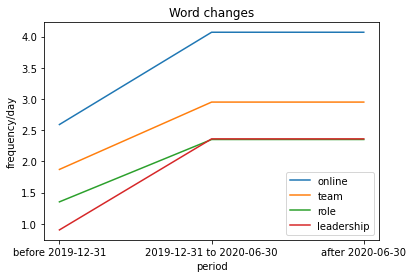

In [38]:
plot(preplot(relatedword,change1,change2,type1p1),period)